# Test coordinates

In [1]:
import mne
import nibabel as nb
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
# Load position of the electrodes
elec_pos = '/home/mcesped/scratch/Results/seegprep/hipp_run/bids/sub-068/ses-005/ieeg/sub-068_ses-005_task-full_rec-regionID_run-01_regions_native_space.tsv'
elec_df = pd.read_csv(elec_pos, sep='\t')
elec_df.head()

,type,group,label,x_init,x_end,y_init,y_end,z_init,z_end,region ID,region name,r,g,b
0,SEEGA,LAIn,LAIn1-2,-33.948,-32.609,44.602,45.995,-0.933,1.646,0,Unknown,0,0,0
1,SEEGA,LAIn,LAIn2-3,-32.609,-31.847,45.995,46.867,1.646,3.742,0,Unknown,0,0,0
2,SEEGA,LAIn,LAIn3-4,-31.847,-30.644,46.867,48.118,3.742,6.166,0,Unknown,0,0,0
3,SEEGA,LAIn,LAIn4-5,-30.644,-29.500,48.118,49.173,6.166,8.611,0,Unknown,0,0,0
4,SEEGA,LAIn,LAIn5-6,-29.500,-28.387,49.173,50.579,8.611,11.046,0,Unknown,0,0,0


In [5]:
mri_ras_mm = elec_df[
        ['x_init', "y_init", "z_init"]
    ].values

In [7]:
mri_ras_mm

array([[-33.948,  44.602,  -0.933],
       [-32.609,  45.995,   1.646],
       [-31.847,  46.867,   3.742],
       [-30.644,  48.118,   6.166],
       [-29.5  ,  49.173,   8.611],
       [-28.387,  50.579,  11.046],
       [-27.595,  51.552,  13.48 ],
       [-26.295,  52.748,  15.908],
       [-25.288,  54.058,  18.329],
       [-10.975,  72.472,  -8.3  ],
       [-14.834,  71.893,  -4.652],
       [-18.877,  71.436,  -0.452],
       [-22.996,  70.926,   3.925],
       [-27.351,  70.197,   8.442],
       [-32.169,  70.014,  12.024],
       [-36.505,  69.542,  16.345],
       [-40.595,  69.437,  20.871],
       [-45.211,  68.749,  24.765],
       [-13.594,  -9.547,  21.046],
       [-19.581,  -8.733,  20.589],
       [-25.469,  -7.889,  20.934],
       [-31.397,  -7.062,  21.094],
       [-37.188,  -6.323,  20.468],
       [-43.122,  -5.534,  20.254],
       [-49.038,  -4.411,  20.157],
       [-54.72 ,  -3.146,  20.117],
       [-60.453,  -2.141,  20.104],
       [-35.788,  23.723,   

In [3]:
elec_df[elec_df['label']=='RHc1-2']

,type,group,label,x_init,x_end,y_init,y_end,z_init,z_end,region ID,region name,r,g,b
54,SEEGA,RHc,RHc1-2,20.825,24.809,18.567,18.432,-7.997,-8.099,2,CA1,0,255,0


In [4]:
pos_test = [22.81, 18.593, -8.192]

In [5]:
def readRegMatrix(trsfPath):
	with open(trsfPath) as (f):
		return np.loadtxt(f.readlines())

In [6]:
tf_7T_to_clinical = '/home/mcesped/scratch/Results/seegprep/hipp_run/work/sub-068/anat/sub-068_tf.txt'
tf_obj = readRegMatrix(tf_7T_to_clinical)

In [7]:
# Get pos in 7T space
pos_7T = mne.transforms.apply_trans(tf_obj, pos_test)

In [8]:
# Load the 7T to check that it's okay
img_7T = '/home/mcesped/scratch/Results/hippunfold/batch-hippunfold/hippunfold/sub-P060/anat/sub-P060_desc-preproc_T1w.nii.gz'
t1_obj = nb.load(img_7T)

In [9]:
# Visualize in 7T space
inv_affine = np.linalg.inv(t1_obj.affine)
vox = np.round(mne.transforms.apply_trans(inv_affine, pos_7T)).astype(int)
vox

array([151, 161, 149])

In [10]:
def imshow_mri(data, img, vox, suptitle, cmap='gray', vmin=None, vmax=None):
    """Show an MRI slice with a voxel annotated."""
    i, j, k = vox
    fig, ax = plt.subplots()
    codes = nb.orientations.aff2axcodes(img.affine)
    # Figure out the title based on the code of this axis
    ori_slice = dict(P='Coronal', A='Coronal',
                     I='Axial', S='Axial',
                     L='Sagittal', R='Saggital')
    ori_names = dict(P='posterior', A='anterior',
                     I='inferior', S='superior',
                     L='left', R='right')
    title = ori_slice[codes[0]]
    scale = np.max(data.shape[2]/data.shape[1])
    ax.imshow(data[i], cmap=cmap, origin='lower', aspect=scale*0.8, vmin=vmin, vmax=vmax)
    # reorient view so that RAS is always rightward and upward
    x_order = -1 if codes[2] in 'LIP' else 1
    y_order = -1 if codes[1] in 'LIP' else 1
    ax.set(xlim=[0, data.shape[2] - 1][::x_order],
           ylim=[0, data.shape[1] - 1][::y_order],
           xlabel=f'k ({ori_names[codes[2]]}+)',
           ylabel=f'j ({ori_names[codes[1]]}+)',
           title=f'{title} view: i={i} ({ori_names[codes[0]]}+)')
    fig.suptitle(suptitle)
    fig.subplots_adjust(0.1, 0.1, 0.95, 0.85)
    return fig

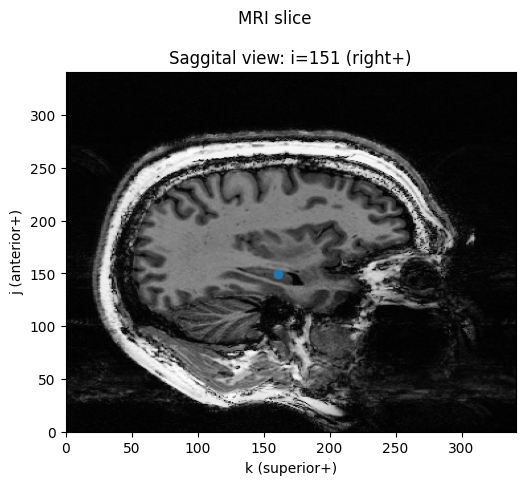

In [11]:
data = np.asarray(t1_obj.dataobj)
dataplot = np.swapaxes(data, 1, 2)
fig = imshow_mri(dataplot, t1_obj, vox, 'MRI slice')
fig.axes[0].scatter(vox[1],vox[2])

In [14]:
# Now load the 2 nifti files with the coordinates
import os
coord_dir = '/home/mcesped/scratch/Results/hippunfold/batch-hippunfold/hippunfold/sub-P060/coords/'
ap_img = nb.load(os.path.join(coord_dir, 'sub-P060_dir-AP_hemi-R_space-cropT1w_label-hipp_desc-laplace_coords.nii.gz'))
pd_img =  nb.load(os.path.join(coord_dir, 'sub-P060_dir-PD_hemi-R_space-cropT1w_label-hipp_desc-laplace_coords.nii.gz'))

In [48]:
# Find the AP-PD value based on these 2 images
#AP
inv_affine = np.linalg.inv(ap_img.affine)
vox = np.round(mne.transforms.apply_trans(inv_affine, pos_7T)).astype(int)
AP_coord = ap_img.get_fdata()[tuple(vox)]
vox, AP_coord

(array([174, 164, 112]), 0.28496554493904114)

In [49]:
#PD
# Not necessary to calculate vox again
PD_coord = pd_img.get_fdata()[tuple(vox)]
vox, PD_coord

(array([174, 164, 112]), 1.0)

In [50]:
coord_2D = (AP_coord, PD_coord)
coord_2D

(0.28496554493904114, 1.0)

In [109]:
# Now load the shape.gii files for the AP, PD mapping to the midthickness
# To find the closest vertex, do a zip list of the values in the 2 shape.gii images
# and find the closest value to the previous AP,PD value found for the electrode.
gifti_dir = '/home/mcesped/scratch/Results/'
ap_gifti = nb.load(os.path.join(gifti_dir, 'sub-P060_AP_midthickness.shape.gii'))
pd_gifti =  nb.load(os.path.join(gifti_dir, 'sub-P060_PD_midthickness.shape.gii'))

In [64]:
ap_gifti.agg_data()

array([0.01182907, 0.05805763, 0.07515345, ..., 0.38616118, 0.39667782,
       0.40172216], dtype=float32)

In [110]:
coords_AP_PD = np.hstack([ap_gifti.agg_data()[:,np.newaxis], ap_gifti.agg_data()[:,np.newaxis]])

In [57]:
from scipy import spatial

In [67]:
coords_AP_PD[spatial.KDTree(coords_AP_PD).query(coord_2D)[1]]

array([0.29060456, 0.98842204], dtype=float32)

In [85]:
def electrode_mask(coord, coord0=(0,0), r=1):
    if (coord[0]-coord0[0])**2 + (coord[1]-coord0[1])**2 <= r**2:
        return 1
    else:
        return 0

In [101]:
from functools import partial
result = list(map(partial(electrode_mask, coord0 = coord_2D, r=0.1), coords_AP_PD))

In [102]:
mask_2d = np.array(result)

In [103]:
mask_2d

array([0, 0, 0, ..., 0, 0, 0])

In [140]:
meta=nb.gifti.gifti.GiftiMetaData({'AnatomicalStructurePrimary': ap_gifti.meta['AnatomicalStructurePrimary']})
datarray = nb.gifti.gifti.GiftiDataArray(mask_2d, datatype=ap_gifti.darrays[0].datatype)
mask_gifti = nb.gifti.gifti.GiftiImage(header=ap_gifti.header, file_map = ap_gifti.file_map, meta=meta, labeltable=ap_gifti.labeltable, darrays=[datarray])

In [141]:
mask_gifti.to_filename('test_mask.shape.gii')

# Tests with data

## Get the data

In [1]:
from bids import BIDSLayout
import pandas as pd
import numpy as np
import scipy
import json
import pyedflib
import re
import nibabel as nb
import os
import xarray as xr

In [3]:
# Load dataset
data_path = '/scratch/mcesped/Results/seegprep/hipp_run/bids/'
layout = BIDSLayout(data_path, validate=False)
layout_edf = BIDSLayout('/scratch/mcesped/Results/seegprep/hipp_run/work/', validate=False)

In [4]:
tsv_files = layout.get(extension='tsv', suffix='space')
tsv_files
# ieeg_files = layout_edf.get(extension='edf', suffix='ieeg', reconstruction='PLIreject')

[<BIDSDataFile filename='/scratch/mcesped/Results/seegprep/hipp_run/bids/sub-002/ses-002/ieeg/sub-002_ses-002_task-full_rec-regionID_run-01_regions_native_space.tsv'>,
 <BIDSDataFile filename='/scratch/mcesped/Results/seegprep/hipp_run/bids/sub-003/ses-007/ieeg/sub-003_ses-007_task-full_rec-regionID_run-02_regions_native_space.tsv'>,
 <BIDSDataFile filename='/scratch/mcesped/Results/seegprep/hipp_run/bids/sub-003/ses-008/ieeg/sub-003_ses-008_task-full_rec-regionID_run-01_regions_native_space.tsv'>,
 <BIDSDataFile filename='/scratch/mcesped/Results/seegprep/hipp_run/bids/sub-009/ses-001/ieeg/sub-009_ses-001_task-full_rec-regionID_run-01_regions_native_space.tsv'>,
 <BIDSDataFile filename='/scratch/mcesped/Results/seegprep/hipp_run/bids/sub-009/ses-002/ieeg/sub-009_ses-002_task-full_rec-regionID_run-01_regions_native_space.tsv'>,
 <BIDSDataFile filename='/scratch/mcesped/Results/seegprep/hipp_run/bids/sub-009/ses-004/ieeg/sub-009_ses-004_task-full_rec-regionID_run-01_regions_native_space

In [19]:
sub_sess_info = dict()
for tsv_file in tsv_files:
    # Get tsv file
    subj = tsv_file.get_entities()['subject']
    session = tsv_file.get_entities()['session']
    run = tsv_file.get_entities()['run']
    edf_files = layout_edf.get(extension='edf', suffix='ieeg', reconstruction='PLIreject', subject=subj, session=session, run=run, return_type='filename')
    # Append to dict
    sub_sess_info[f'sub-{subj}_ses-{session}_run-{run}'] = {
        'channels_tsv': tsv_file.path,
        'edf_files' : edf_files,
        'subject': subj
    }

In [20]:
sub_sess_info[list(sub_sess_info.keys())[95]]

{'channels_tsv': '/scratch/mcesped/Results/seegprep/hipp_run/bids/sub-078/ses-008/ieeg/sub-078_ses-008_task-full_rec-regionID_run-01_regions_native_space.tsv',
 'edf_files': ['/scratch/mcesped/Results/seegprep/hipp_run/work/sub-078/ses-008/ieeg/sub-078_ses-008_task-full_rec-PLIreject_run-01_clip-01_ieeg.edf'],
 'subject': '078'}

## MTS analysis

In [47]:
import copy
# Load snsx data
snsx_path = './snsx_data_collection.csv'
snsx_df = pd.read_csv(snsx_path, sep=',')
# Load mapping snsx to clinical
mapping = pd.read_csv('mapping_snsx_clinical.tsv', sep='\t')
mapping_dict = dict(zip(mapping['ieeg_subject'].to_list(), mapping['snsx_subject'].to_list()))
# Create new data
time_data = np.array([])
# Dims (n x time)
# Coordinates: subj, chn, type (MTS_contra, MTS_ipsi), PD coord, AP coord
subj_ses_run_chn = []
subjs = []
chns = []
type_epi = []
PD_coords = np.array([])
AP_coords = np.array([])

for sub_sess in sub_sess_info:
    # Get bad hemispheres
    subj_clinical = sub_sess_info[sub_sess]['subject']
    subj_snsx = 'sub-' + mapping_dict[f"P{subj_clinical}"]
    # print(subj_snsx)
    generalized, bilobal, bad_R, bad_L, MTS = snsx_df[snsx_df['participant_id']==subj_snsx][['Generalized', 'Bilobal', 'Right ', 'Left', 'MRI (0=no/1=yes) MTS']].to_numpy().squeeze().astype(bool)
    # print(bad_R, bad_L)
    # Get info from channels.tsv of channels actually in the hippocampus
    loc_df = pd.read_csv(sub_sess_info[sub_sess]['channels_tsv'], sep='\t').dropna()
    # Get info per edf file
    for edf_path in sub_sess_info[sub_sess]['edf_files']:
        edf = pyedflib.EdfReader(edf_path)
        # Get chn labels
        edf_chns = edf.getSignalLabels()
        for chn in loc_df['label'].to_numpy():
            if (not generalized) and MTS:
                # Append data
                data = edf.readSignal(edf_chns.index(chn))
                time_data = np.vstack([time_data.reshape(-1,len(data)), data])
                # Add coords 
                subj_ses_run_chn.append(sub_sess+f'_{chn}')
                subjs.append(subj_clinical)
                chns.append(chn)
                # Add coords AP-PD
                PD_coords = np.hstack([PD_coords, loc_df[loc_df['label']==chn]['PD'].to_numpy()])
                AP_coords = np.hstack([AP_coords, loc_df[loc_df['label']==chn]['AP'].to_numpy()])
                # Right hemi
                good_R = (loc_df[loc_df['label']==chn]['x'].values[0] > 0) and not bad_R
                # Left hemi
                good_L = (loc_df[loc_df['label']==chn]['x'].values[0] < 0) and not bad_L
                # Contra-lateral MTS TLE
                if not bilobal and (good_R or good_L):
                    type_epi.append('contra_MTS')
                # Ipsilateral TLE
                else:
                    type_epi.append('ipsi_MTS')   
        edf.close()

In [48]:
len(subj_ses_run_chn)

166

In [49]:
# Convert to xarray dataset
ds_MTS = xr.Dataset(
    {'time_domain' : (['n', 'time'], time_data)},
    coords={
        "subj": (["n"], subjs),
        "chn": (["n"], chns),
        "group": (["n"], type_epi),
        "subj_ses_run_chn": (["n"], subj_ses_run_chn),
        "PD": (["n"], PD_coords),
        "AP": (["n"], AP_coords),
        "time": np.arange(time_data.shape[-1])/200,
        'n': np.arange(time_data.shape[0])
    },
)

In [50]:
ds_MTS

<xarray.Dataset>
Dimensions:           (n: 166, time: 48000)
Coordinates:
    subj              (n) <U3 '016' '016' '016' '016' ... '083' '083' '083'
    chn               (n) <U9 'RAHc1-2' 'RAHc2-3' ... 'RPHc1-2' 'RPHc2-3'
    group             (n) <U10 'contra_MTS' 'contra_MTS' ... 'contra_MTS'
    subj_ses_run_chn  (n) <U32 'sub-016_ses-001_run-01_RAHc1-2' ... 'sub-083_...
    PD                (n) float64 0.9963 0.4899 0.9963 ... 0.6346 0.5208 0.6346
    AP                (n) float64 0.2397 0.2849 0.2397 ... 0.5375 0.5737 0.5375
  * time              (time) float64 0.0 0.005 0.01 0.015 ... 240.0 240.0 240.0
  * n                 (n) int64 0 1 2 3 4 5 6 7 ... 159 160 161 162 163 164 165
Data variables:
    time_domain       (n, time) float64 -1.672 -5.016 -24.6 ... 34.69 -0.1329

In [51]:
ds_MTS.to_netcdf("ds_MTS_time.nc")

## Frequency domain

In [52]:
# Get data in frequency domain
import analysis
ds_MTS_freq = analysis.psd_xarray(ds_MTS, 200)
ds_MTS_freq

(166, 201)


<xarray.Dataset>
Dimensions:           (n: 166, time: 48000, frequency: 159)
Coordinates:
    subj              (n) <U3 '016' '016' '016' '016' ... '083' '083' '083'
    chn               (n) <U9 'RAHc1-2' 'RAHc2-3' ... 'RPHc1-2' 'RPHc2-3'
    group             (n) <U10 'contra_MTS' 'contra_MTS' ... 'contra_MTS'
    subj_ses_run_chn  (n) <U32 'sub-016_ses-001_run-01_RAHc1-2' ... 'sub-083_...
    PD                (n) float64 0.9963 0.4899 0.9963 ... 0.6346 0.5208 0.6346
    AP                (n) float64 0.2397 0.2849 0.2397 ... 0.5375 0.5737 0.5375
  * time              (time) float64 0.0 0.005 0.01 0.015 ... 240.0 240.0 240.0
  * n                 (n) int64 0 1 2 3 4 5 6 7 ... 159 160 161 162 163 164 165
  * frequency         (frequency) float64 0.5 1.0 1.5 2.0 ... 78.5 79.0 79.5
Data variables:
    time_domain       (n, time) float64 -1.672 -5.016 -24.6 ... 34.69 -0.1329
    psd               (n, frequency) float64 0.6393 0.5883 ... 2.889e-05

## Bandpower analysis

In [55]:
ds_MTS_freq = analysis.compute_bandpower(ds_MTS_freq, 'group')
ds_MTS_freq

<xarray.Dataset>
Dimensions:           (n: 166, time: 48000, frequency: 159, f_bands: 5)
Coordinates:
    subj              (n) <U3 '016' '016' '016' '016' ... '083' '083' '083'
    chn               (n) <U9 'RAHc1-2' 'RAHc2-3' ... 'RPHc1-2' 'RPHc2-3'
    group             (n) <U10 'contra_MTS' 'contra_MTS' ... 'contra_MTS'
    subj_ses_run_chn  (n) <U32 'sub-016_ses-001_run-01_RAHc1-2' ... 'sub-083_...
    PD                (n) float64 0.9963 0.4899 0.9963 ... 0.6346 0.5208 0.6346
    AP                (n) float64 0.2397 0.2849 0.2397 ... 0.5375 0.5737 0.5375
  * time              (time) float64 0.0 0.005 0.01 0.015 ... 240.0 240.0 240.0
  * n                 (n) int64 0 1 2 3 4 5 6 7 ... 159 160 161 162 163 164 165
  * frequency         (frequency) float64 0.5 1.0 1.5 2.0 ... 78.5 79.0 79.5
  * f_bands           (f_bands) <U5 'delta' 'theta' 'alpha' 'beta' 'gamma'
Data variables:
    time_domain       (n, time) float64 -1.672 -5.016 -24.6 ... 34.69 -0.1329
    psd               (n, frequency) float64 0.6393 0.5883 ... 2.889e-05
    bandpow           (n, f_bands) float64 0.6766 0.09419 ... 0.01758 0.007487

In [104]:
import seaborn as sns
import matplotlib.pyplot as plt

In [97]:
MTS_bandpow = ds_MTS_freq['bandpow']

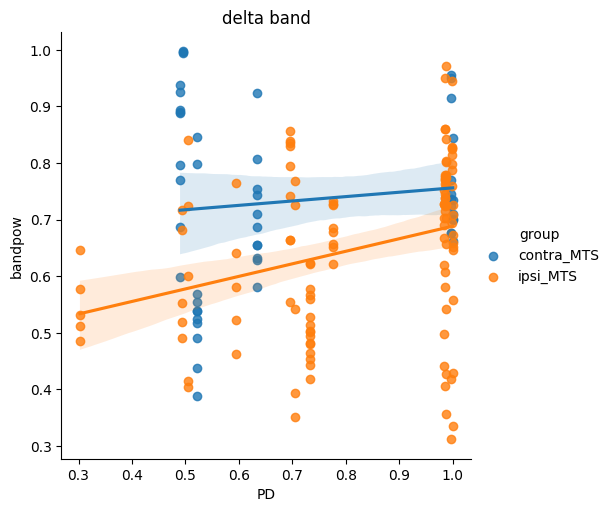

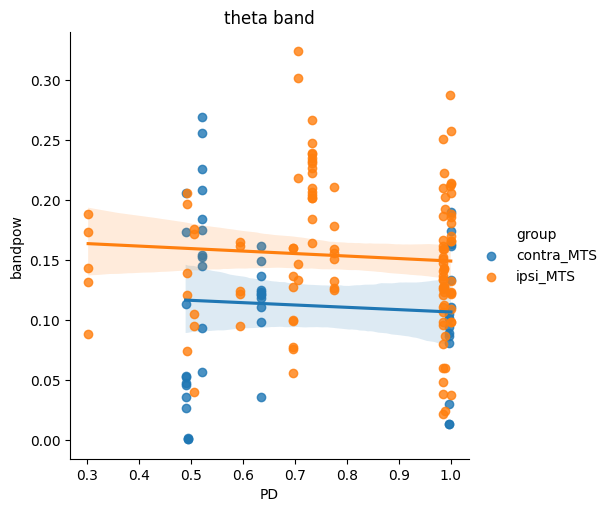

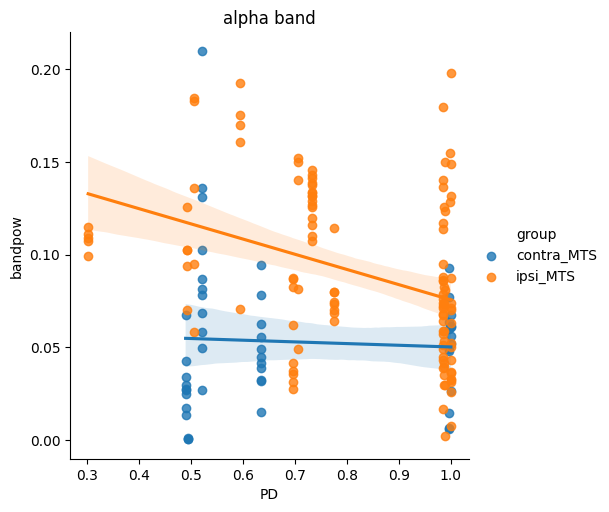

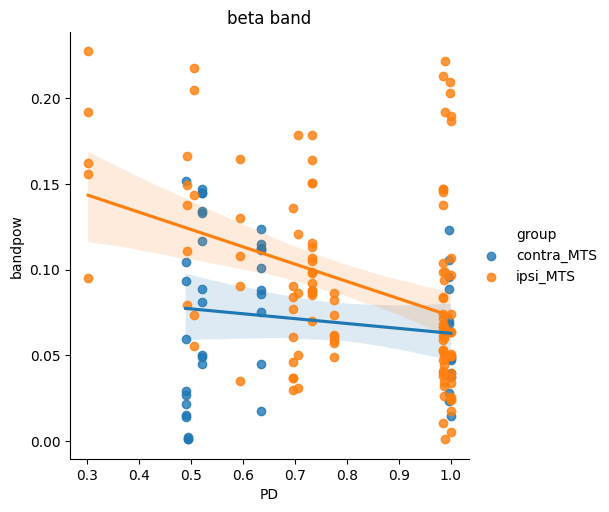

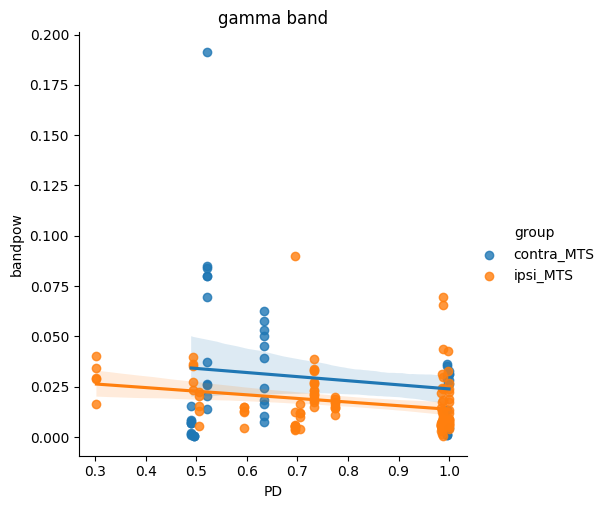

In [106]:
for band in MTS_bandpow['f_bands'].to_numpy():
    df_MTS_band = MTS_bandpow.where(MTS_bandpow.f_bands==band,drop=True).reset_index(['f_bands']).to_dataframe().reset_index(drop=True)
    sns.lmplot( x = "PD", 
                y = "bandpow", 
                hue = "group",
                data = df_MTS_band)
    ax = plt.gca()
    ax.set_title(f'{band} band')

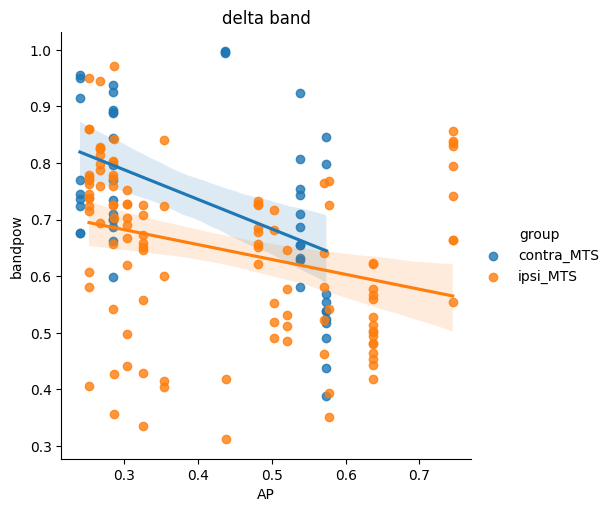

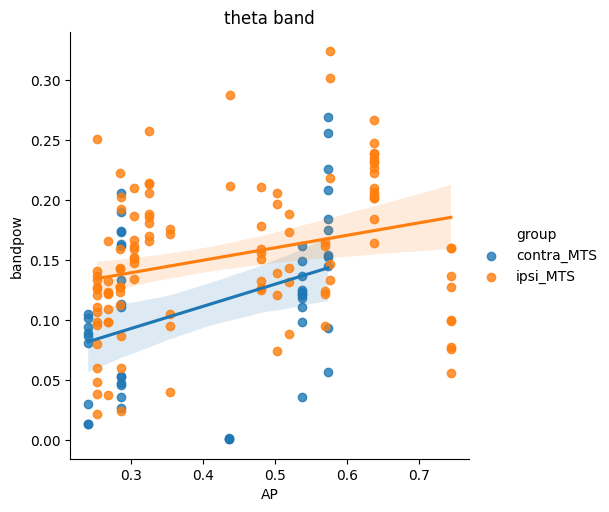

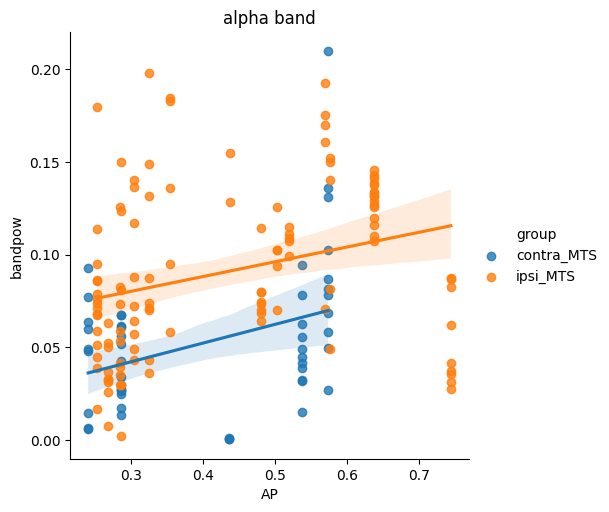

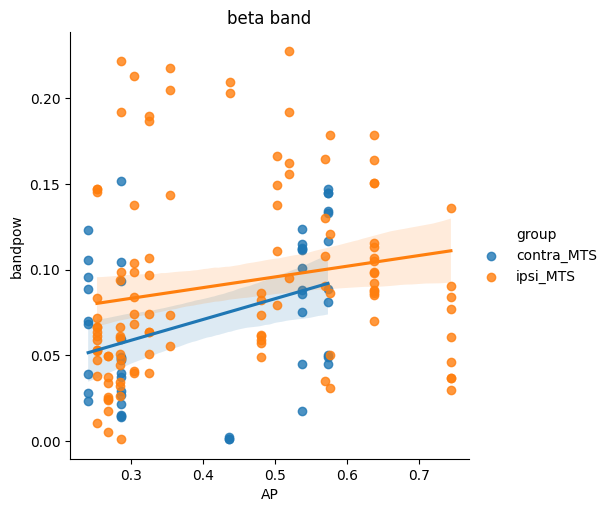

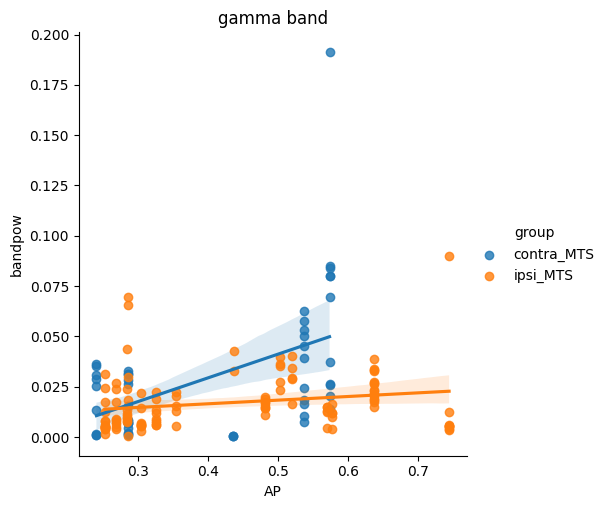

In [108]:
for band in MTS_bandpow['f_bands'].to_numpy():
    df_MTS_band = MTS_bandpow.where(MTS_bandpow.f_bands==band,drop=True).reset_index(['f_bands']).to_dataframe().reset_index(drop=True)
    sns.lmplot( x = "AP", 
                y = "bandpow", 
                hue = "group",
                data = df_MTS_band)
    ax = plt.gca()
    ax.set_title(f'{band} band')